In [1]:
import torch
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from src.model import Discriminator, Generator, CLEARWassersteinCritic
from src.trainer import GAN, WGAN, CLEARWGAN

In [4]:

from src.utils import generate_style_dict, KStyledMNIST, KStyledMNISTGenerator

In [5]:
np.random.seed(101)
torch.manual_seed(101)
mnist = torchvision.datasets.MNIST(
    "../data", train=True, download=True
)

style_fns = [
    corruptions.identity,
    corruptions.stripe,
    corruptions.zigzag,
    lambda x: corruptions.scale(x, 5),
    corruptions.brightness,
]

In [6]:
def get_data_splits(k: int, seed: int, style_fns=style_fns):
    """
    Generate data splits and style dictionaries for k styled MNIST dataset

    Parameters:
        k (int): The number of styles to generate for each class
        seed (int): The random seed for reproducibility

    Returns:
        style_dict (dict): A dictionary containing the style information for each class
        train (k styled MNIST)
        valid (k styled MNIST)
        test (m-k styled MNIST)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    mnist = torchvision.datasets.MNIST("../data", train=True)
    mnist_train, mnist_test = random_split(mnist, [50000, 10000])
    style_dict = generate_style_dict(classes=list(range(10)), style_fns=style_fns, k=k)
    mnist_generator = KStyledMNISTGenerator(mnist_train, style_dict, "train", style_fns)
    train = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    mnist_generator = KStyledMNISTGenerator(mnist_test, style_dict, "test", style_fns)
    test = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    train_size = int(0.85 * len(train))
    train, valid = random_split(train, [train_size, len(train) - train_size])
    return style_dict, train, valid, test

In [7]:
style_dict, train, valid, test = get_data_splits(k=2, seed=101)

Generating dataset: 100%|██████████| 10000/10000 [00:01<00:00, 5112.38item/s]


In [8]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)

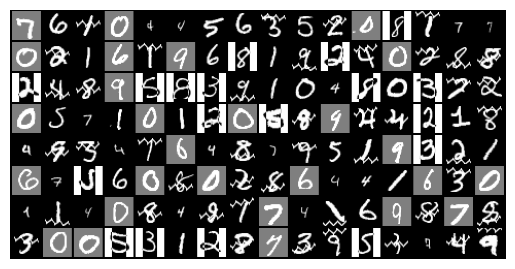

In [9]:
X, label, _ = next(iter(train_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()

In [ ]:
from src.utils import StyledMNISTGenerator, StyledMNIST

generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)

dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


### GAN

In [ ]:
model = GAN(
    generator=Generator(z_dim=64),
    discriminator=Discriminator(),
    lr={"D": 2e-4, "G": 1e-4},
    verbose_period=2,
    device=device
)

In [ ]:
d_losses, g_losses = model.fit(15, train_loader)
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses}
).plot(kind="line")
plt.show()

In [ ]:
z = torch.randn(128, model.generator.z_dim, 1, 1).to(device)
xhat = model.generator(z).detach().cpu()
plt.imshow(torch.permute(make_grid(xhat, nrow=16), (1, 2, 0)))
plt.show()

### WGAN-GP

In [ ]:
model = WGAN(
    generator=Generator(z_dim=64),
    discriminator=Discriminator(gan_type="wasserstein"),
    lr={"D": 2e-4, "G": 1e-4},
    hyperparam={"lambda_gp": 10, "n_critic": 5},
    verbose_period=2,
    device=device
)

In [45]:
d_losses, g_losses = model.fit(11, train_loader)

Epoch 10: 100%|██████████| 333/333 [00:47<00:00,  6.94batch/s, d_loss=-6.53, g_loss=-9.56]


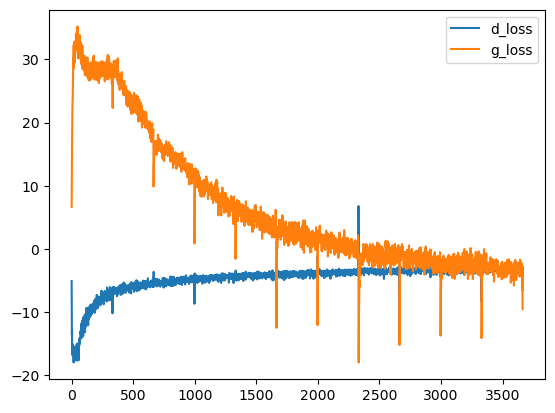

In [46]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses}
).plot(kind="line")
plt.show()

In [52]:
for i in style_dict.keys():
    print(i, style_dict[i]["train"])

0 [<function identity at 0x00000209FA766CB0>, <function brightness at 0x00000209FA765CF0>]
1 [<function identity at 0x00000209FA766CB0>, <function zigzag at 0x00000209FA7667A0>]
2 [<function zigzag at 0x00000209FA7667A0>, <function stripe at 0x00000209FA766950>]
3 [<function stripe at 0x00000209FA766950>, <function zigzag at 0x00000209FA7667A0>]
4 [<function zigzag at 0x00000209FA7667A0>, <function <lambda> at 0x000002098E2C55A0>]
5 [<function stripe at 0x00000209FA766950>, <function identity at 0x00000209FA766CB0>]
6 [<function brightness at 0x00000209FA765CF0>, <function identity at 0x00000209FA766CB0>]
7 [<function <lambda> at 0x000002098E2C55A0>, <function brightness at 0x00000209FA765CF0>]
8 [<function zigzag at 0x00000209FA7667A0>, <function stripe at 0x00000209FA766950>]
9 [<function brightness at 0x00000209FA765CF0>, <function zigzag at 0x00000209FA7667A0>]


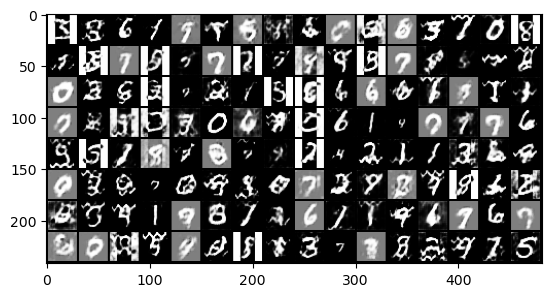

In [60]:
z = torch.randn(128, model.generator.z_dim, 1, 1).to(device)
xhat = model.generator(z).detach().cpu()
plt.imshow(torch.permute(make_grid(xhat, nrow=16), (1, 2, 0)))
plt.show()

In [79]:
model.disciminator(xhat.to(device)).squeeze().mean()

tensor(10.3792, device='cuda:0', grad_fn=<MeanBackward0>)

In [74]:
model.disciminator(next(iter(train_loader))[0].to(device)).mean()

tensor(11.4704, device='cuda:0', grad_fn=<MeanBackward0>)

In [78]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
model.disciminator(next(iter(test_loader))[0].to(device)).mean()

tensor(10.7332, device='cuda:0', grad_fn=<MeanBackward0>)

In [80]:
torch.cuda.empty_cache()

In [ ]:
# max D(real) - D(fake)

### CLEAR-GAN

In [30]:
cleargan = CLEARWGAN(
    generator=Generator(z_dim=64),
    critic=CLEARWassersteinCritic(z_dim=10),
    lr={"D": 2e-4, "G": 1e-4},
    hyperparam={"lambda_gp": 10, "lambda_clear": 1e2, 
                "n_critic": 5, "temperature": 0.1},
    verbose_period=2,
    device=device
)

In [34]:
d_losses, g_losses = cleargan.fit(5, train_loader)

Epoch 4: 100%|██████████| 333/333 [00:55<00:00,  6.04batch/s, anticontrast_s=0.000228, contrast_c=7.68e-5, d_loss=0.943, g_loss=2.24]


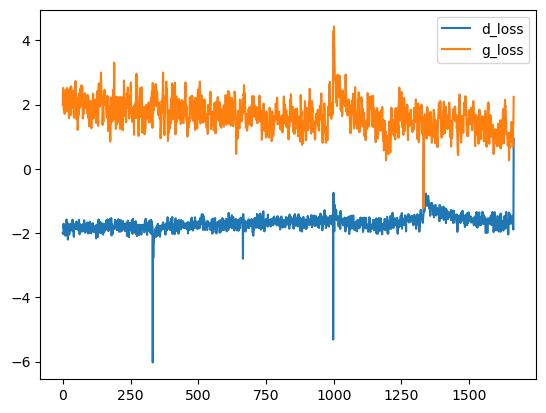

In [35]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses}
).plot(kind="line")
plt.show()

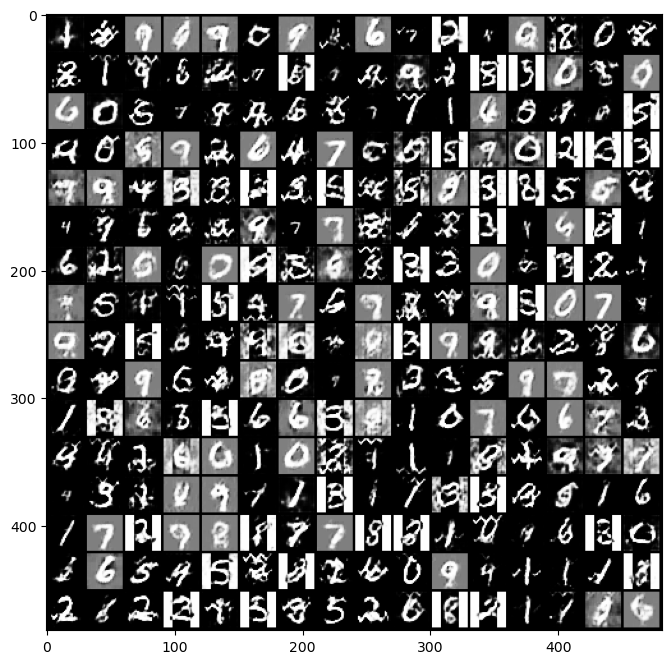

In [43]:
z = torch.randn(256, cleargan.generator.z_dim, 1, 1).to(device)
xhat = cleargan.generator(z).detach().cpu()
plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(make_grid(xhat, nrow=16), (1, 2, 0)))
plt.show()

In [18]:
for i in style_dict.keys():
    print(i, style_dict[i]["train"])

0 [<function identity at 0x00000209FA766CB0>, <function brightness at 0x00000209FA765CF0>]
1 [<function identity at 0x00000209FA766CB0>, <function zigzag at 0x00000209FA7667A0>]
2 [<function zigzag at 0x00000209FA7667A0>, <function stripe at 0x00000209FA766950>]
3 [<function stripe at 0x00000209FA766950>, <function zigzag at 0x00000209FA7667A0>]
4 [<function zigzag at 0x00000209FA7667A0>, <function <lambda> at 0x000002098E2C55A0>]
5 [<function stripe at 0x00000209FA766950>, <function identity at 0x00000209FA766CB0>]
6 [<function brightness at 0x00000209FA765CF0>, <function identity at 0x00000209FA766CB0>]
7 [<function <lambda> at 0x000002098E2C55A0>, <function brightness at 0x00000209FA765CF0>]
8 [<function zigzag at 0x00000209FA7667A0>, <function stripe at 0x00000209FA766950>]
9 [<function brightness at 0x00000209FA765CF0>, <function zigzag at 0x00000209FA7667A0>]


In [19]:
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
with torch.no_grad():
    all_c, all_s = [], []
    all_content_label, all_style_label = [], []
    for batch in valid_loader:
        x = batch[0].to(device)
        c_label, s_label = batch[1], batch[2]
        _, c, s = cleargan.critic(x)
        all_c.append(c.squeeze())
        all_s.append(s.squeeze())
        all_content_label.append(c_label)
        all_style_label.append(s_label)

In [ ]:
all_style_label = torch.cat(all_style_label).numpy()

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
c_tsne = tsne.fit_transform(torch.cat(all_c).cpu().numpy())

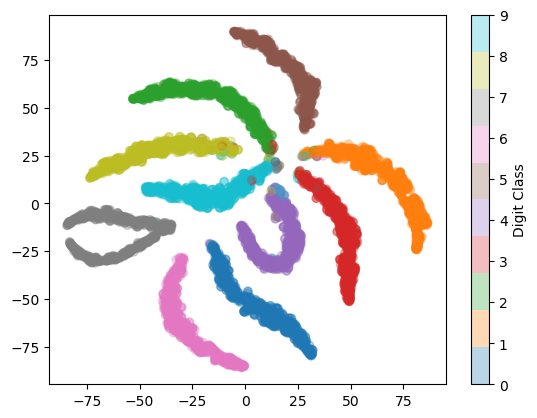

In [21]:
plt.scatter(c_tsne[:, 0], c_tsne[:, 1], alpha=0.3, 
            c=torch.cat(all_content_label).cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

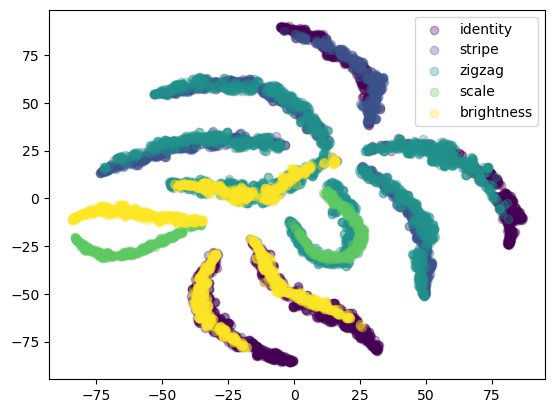

In [39]:
style_labels = ['identity', 'stripe', 'zigzag', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(all_style_label == g)[0]
    ax.scatter(c_tsne[i,0], c_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
s_tsne = tsne.fit_transform(torch.cat(all_s).cpu().numpy())

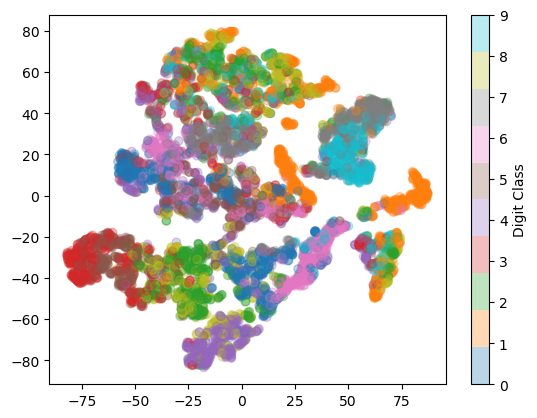

In [26]:
plt.scatter(s_tsne[:, 0], s_tsne[:, 1], alpha=0.3, 
            c=torch.cat(all_content_label).cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

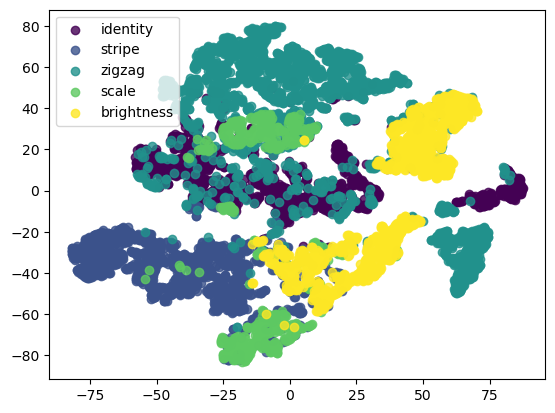

In [40]:
style_labels = ['identity', 'stripe', 'zigzag', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(all_style_label == g)[0]
    ax.scatter(s_tsne[i,0], s_tsne[i,1], alpha=0.8, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()